In [1]:
!pip install pgmpy --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.8 MB/s eta 0:00:00


#  Import Libraries

In [2]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

#Defining the structure (the "skeleton") of Bayesian Network.

In [3]:
placement_model = DiscreteBayesianNetwork([
    ('C', 'W'),  # CGPA → Written Test
    ('T', 'W'),  # Technical Skills → Written Test
    ('T', 'I'),  # Technical Skills → Interview
    ('S', 'I'),  # Soft Skills → Interview
    ('W', 'J'),  # Written Test → Job Offer
    ('I', 'J')   # Interview → Job Offer
])

 # Define the  Probabilities (CPDs)

In [4]:
cgpa_cpd = TabularCPD('C', 3, [[0.2], [0.5], [0.3]],
                      state_names={'C': ['Low', 'Medium', 'High']})

tech_cpd = TabularCPD('T', 2, [[0.4], [0.6]],
                      state_names={'T': ['Weak', 'Strong']})

soft_cpd = TabularCPD('S', 2, [[0.5], [0.5]],
                      state_names={'S': ['Weak', 'Strong']})

written_cpd = TabularCPD(
    variable='W', variable_card=2,
    values=[[0.8, 0.6, 0.3, 0.4, 0.2, 0.1],
            [0.2, 0.4, 0.7, 0.6, 0.8, 0.9]],
    evidence=['C', 'T'],
    evidence_card=[3, 2],
    state_names={'W': ['Fail', 'Pass'],
                 'C': ['Low', 'Medium', 'High'],
                 'T': ['Weak', 'Strong']}
)

interview_cpd = TabularCPD(
    variable='I', variable_card=2,
    values=[[0.7, 0.4, 0.3, 0.1],
            [0.3, 0.6, 0.7, 0.9]],
    evidence=['T', 'S'],
    evidence_card=[2, 2],
    state_names={'I': ['Fail', 'Pass'],
                 'T': ['Weak', 'Strong'],
                 'S': ['Weak', 'Strong']}
)

offer_cpd = TabularCPD(
    variable='J', variable_card=2,
    values=[[0.99, 0.8, 0.6, 0.1],
            [0.01, 0.2, 0.4, 0.9]],
    evidence=['W', 'I'],
    evidence_card=[2, 2],
    state_names={'J': ['No', 'Yes'],
                 'W': ['Fail', 'Pass'],
                 'I': ['Fail', 'Pass']}
)

# Add CPDs to the Model


In [5]:
placement_model.add_cpds(cgpa_cpd, tech_cpd, soft_cpd,
                         written_cpd, interview_cpd, offer_cpd)

print("Model check:", placement_model.check_model())

Model check: True


# Visualize the Network

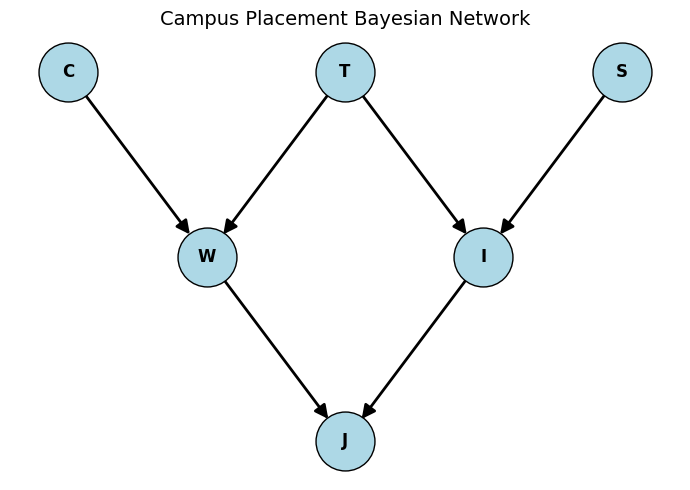

In [9]:
pos = {
    'C': (0, 2),   # CGPA
    'T': (2, 2),   # Technical Skills
    'S': (4, 2),   # Soft Skills
    'W': (1, 1),   # Written Test
    'I': (3, 1),   # Interview
    'J': (2, 0)    # Job Offer
}

plt.figure(figsize=(7, 5))
nx.draw_networkx_nodes(placement_model, pos, node_color='lightblue', node_size=1800, edgecolors='black')
nx.draw_networkx_labels(placement_model, pos, font_size=12, font_weight='bold')
nx.draw_networkx_edges(placement_model, pos, arrows=True, arrowstyle='-|>', arrowsize=20, width=2, node_size=1600)
plt.title("Campus Placement Bayesian Network", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# Inference and Analysis

In [7]:
infer = VariableElimination(placement_model)

# 1. Baseline: P(J)
print("\n P(J):")
print(infer.query(variables=['J']))

# 2. Predictive: P(J | C='High', T='Strong')
print("\nP(J | C='High', T='Strong'):")
print(infer.query(variables=['J'], evidence={'C': 'High', 'T': 'Strong'}))

# 3. Diagnostic: P(T | J='Yes')
print("\n P(T | J='Yes'):")
print(infer.query(variables=['T'], evidence={'J': 'Yes'}))

# 4. Explaining Away
print("\n P(W='Pass' | J='Yes'):")
p1 = infer.query(variables=['W'], evidence={'J': 'Yes'})
print(p1)

print("\nP(W='Pass' | J='Yes', I='Pass'):")
p2 = infer.query(variables=['W'], evidence={'J': 'Yes', 'I': 'Pass'})
print(p2)


 P(J):
+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.4823 |
+--------+----------+
| J(Yes) |   0.5177 |
+--------+----------+

P(J | C='High', T='Strong'):
+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(No)  |   0.2638 |
+--------+----------+
| J(Yes) |   0.7362 |
+--------+----------+

 P(T | J='Yes'):
+-----------+----------+
| T         |   phi(T) |
+===========+==========+
| T(Weak)   |   0.3316 |
+-----------+----------+
| T(Strong) |   0.6684 |
+-----------+----------+

 P(W='Pass' | J='Yes'):
+---------+----------+
| W       |   phi(W) |
+=========+==========+
| W(Fail) |   0.0930 |
+---------+----------+
| W(Pass) |   0.9070 |
+---------+----------+

P(W='Pass' | J='Yes', I='Pass'):
+---------+----------+
| W       |   phi(W) |
+=========+==========+
| W(Fail) |   0.1092 |
+---------+----------+
| W(Pass) |   0.8908 |
+---------+----------+


# Parameter Learning

In [11]:
print("\nGenerating 20,000 samples...")
sampler = BayesianModelSampling(placement_model)
data = sampler.forward_sample(size=20000)
print("Data generated:\n", data.head(10))

# Learn parameters from data
learned_model = DiscreteBayesianNetwork(placement_model.edges())
learned_model.fit(data, estimator=BayesianEstimator)

print("\nComparing original vs learned P(J | W, I):")
print("Original:\n", placement_model.get_cpds('J'))
print("Learned:\n", learned_model.get_cpds('J'))

cpd = learned_model.get_cpds('J')
print(cpd.values)


Generating 20,000 samples...


  0%|          | 0/6 [00:00<?, ?it/s]

Data generated:
         C     W       T     I       S    J
0     Low  Fail  Strong  Pass  Strong  Yes
1  Medium  Pass  Strong  Pass  Strong  Yes
2     Low  Fail    Weak  Fail    Weak   No
3     Low  Pass    Weak  Fail    Weak  Yes
4    High  Pass    Weak  Fail    Weak   No
5    High  Pass  Strong  Fail    Weak   No
6    High  Pass    Weak  Fail  Strong   No
7    High  Pass  Strong  Fail    Weak   No
8  Medium  Fail    Weak  Fail  Strong   No
9  Medium  Pass    Weak  Pass  Strong  Yes

Comparing original vs learned P(J | W, I):
Original:
 +--------+---------+---------+---------+---------+
| W      | W(Fail) | W(Fail) | W(Pass) | W(Pass) |
+--------+---------+---------+---------+---------+
| I      | I(Fail) | I(Pass) | I(Fail) | I(Pass) |
+--------+---------+---------+---------+---------+
| J(No)  | 0.99    | 0.8     | 0.6     | 0.1     |
+--------+---------+---------+---------+---------+
| J(Yes) | 0.01    | 0.2     | 0.4     | 0.9     |
+--------+---------+---------+---------+-------